In [1]:
import typing as t

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from matplotlib import pyplot as plt

In [2]:
torch.manual_seed(0)

transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    transform=transform,
    download=True,
    train=True
)

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

In [3]:
loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=32,
    shuffle=True
)

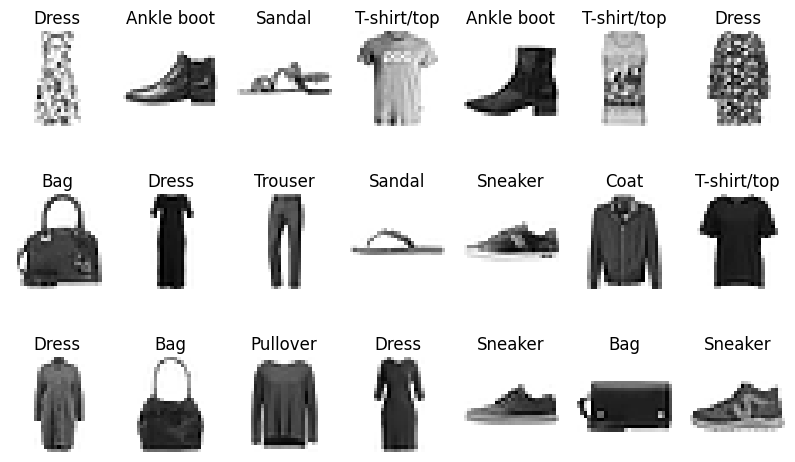

In [4]:
plot_batch = next(iter(loader))

n_rows, n_cols = 3, 7
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(int(n_cols * 1.5), int(n_rows * 2))
)

for i in range(n_rows * n_cols):
  ax_title = idx_to_class[plot_batch[1][i].item()]
  img_show = plot_batch[0][i].permute(1, 2, 0)
  row_id = i // n_cols
  col_id = i % n_cols
  axes[row_id][col_id].set_title(ax_title)
  axes[row_id][col_id].imshow(img_show, cmap='gray_r')
  axes[row_id][col_id].set_axis_off()

plt.show()

In [5]:
def create_discriminator() -> nn.Module:
  # creates discriminator that takes 28x28 image batch
  # and outputs sigmoid of images being true.
  return nn.Sequential(
    nn.Linear(784, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [6]:
def create_generator() -> nn.Module:
  # create generator that generates images with 28x28 shape.
  return nn.Sequential(
    nn.Linear(100, 256),
    nn.ReLU(),

    nn.Linear(256, 512),
    nn.ReLU(),

    nn.Linear(512, 1024),
    nn.ReLU(),

    nn.Linear(1024, 784),
    nn.Tanh()
)

In [7]:
def select_device() -> str:
  return 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
def train_d_on_real_batch(
    model: nn.Module,
    real_batch: torch.tensor,
    optimizer: torch.optim.Optimizer,
    loss_fn: t.Callable,
    device: str
  ) -> float:

  real_batch = real_batch.reshape(-1, 28 * 28)
  batch_size = real_batch.shape[0]
  true_label = torch.ones((batch_size, 1), device=device)

  output = model(real_batch)
  loss = loss_fn(output, true_label)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return 0


def train_d_on_fake_batch(
    model: nn.Module,
    fake_generator: nn.Module,
    batch_size: int,
    optimizer: torch.optim.Optimizer,
    loss_fn: t.Callable,
    device: str
  ) -> float:
  false_label = torch.zeros((batch_size, 1), device=device)
  noize = torch.randn((batch_size, 100), device=device)

  fake_batch = fake_generator(noize)
  output = model(fake_batch)
  loss = loss_fn(output, false_label)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return 0


def train_g_on_d_output(
    model: nn.Module,
    fake_detector: nn.Module,
    batch_size: int,
    optimizer: torch.optim.Optimizer,
    loss_fn: t.Callable,
    device: str
  ) -> float:
  true_label = torch.ones((batch_size, 1), device=device)
  noize = torch.randn((batch_size, 100), device=device)

  fake_output = model(noize)
  detections = fake_detector(fake_output)
  loss = loss_fn(detections, true_label)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return 0

In [9]:
def train_one_epoch(
    d_model: nn.Module,
    g_model: nn.Module,
    d_optimizer: torch.optim.Optimizer,
    g_optimizer: torch.optim.Optimizer,
    loader: torch.utils.data.DataLoader,
    loss_fn: t.Callable,
    device: str
) -> t.Tuple[float, float]:

  epoch_d_loss = 0.
  epoch_g_loss = 0.

  for iter_num, batch in enumerate(loader):
    real_images, _ = batch
    real_images = real_images.to(device)

    train_real_loss = train_d_on_real_batch(
        d_model, real_images, d_optimizer, loss_fn, device
    )
    train_fake_loss = train_d_on_fake_batch(
        d_model, g_model, real_images.shape[0], d_optimizer, loss_fn, device
    )
    train_gen_loss = train_g_on_d_output(
        g_model, d_model, real_images.shape[0], g_optimizer, loss_fn, device
    )

    epoch_d_loss += (train_real_loss + train_fake_loss) / 2
    epoch_g_loss += train_gen_loss
    # print('Finished batch iter', iter_num)

  return epoch_d_loss / len(loader), epoch_g_loss / len(loader)

In [10]:
def generate(g_model: nn.Module, batch_size: int, device: str) -> torch.tensor:
  with torch.no_grad():
    noize = torch.randn((batch_size, 100), device=device)
    fake_output = g_model(noize)
    fake_output = fake_output.reshape(batch_size, 28, 28)
    fake_output = fake_output.detach().cpu()
    return fake_output

In [11]:
def plot_gen_batch(fake_batch: torch.tensor, n_rows: int, n_cols: int) -> None:

  assert fake_batch.shape[0] <= n_rows * n_cols

  fig, axes = plt.subplots(
      n_rows, n_cols,
      figsize=(int(n_cols * 1.5), int(n_rows * 2))
  )

  for i in range(n_rows * n_cols):
    row_id = i // n_cols
    col_id = i % n_cols
    # axes[row_id][col_id].set_axis_off()

    if i < fake_batch.shape[0]:
      img_show = fake_batch[i]
      axes[row_id][col_id].imshow(img_show, cmap='gray_r')

  plt.show()

In [12]:
# gen_fake_batch = generate(g_model, 10, device='cpu')
# plot_gen_batch(gen_fake_batch, 2, 5)

In [13]:
device = select_device()
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

d_model = create_discriminator().to(device)
g_model = create_generator().to(device)

learning_rate = 0.0001
loss_fn = torch.nn.BCELoss()
d_optimizer = torch.optim.Adam(d_model.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(g_model.parameters(), lr=learning_rate)

0 0.0 0.0


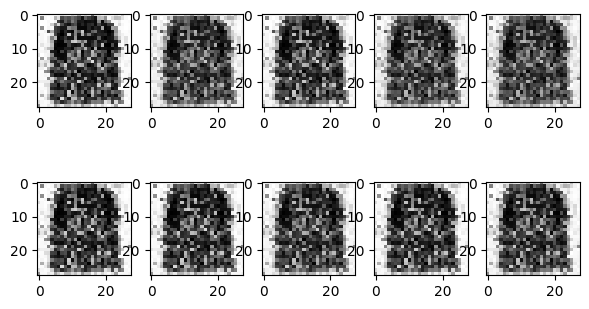

1 0.0 0.0


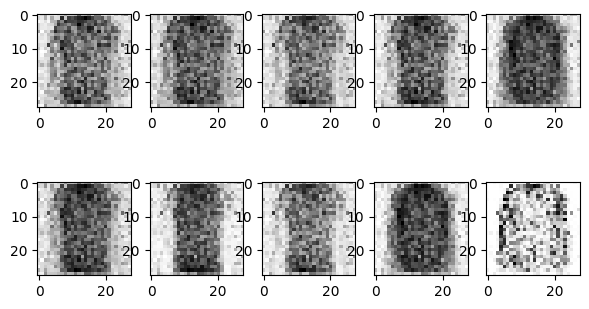

2 0.0 0.0


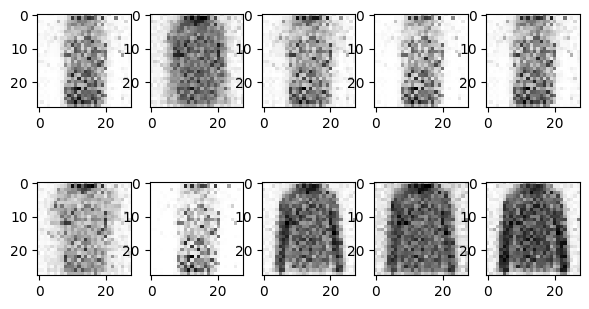

3 0.0 0.0


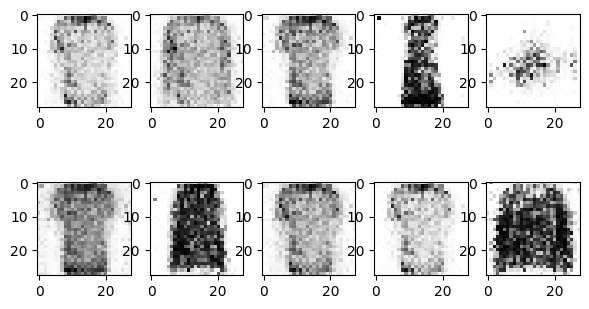

4 0.0 0.0


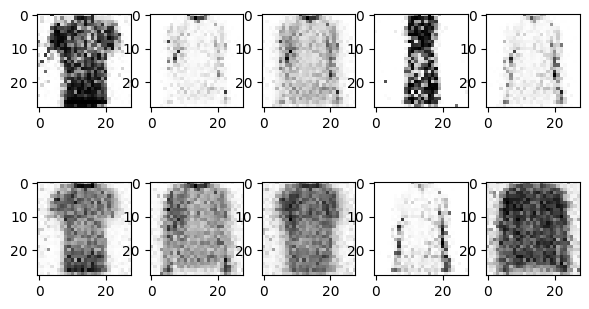

5 0.0 0.0


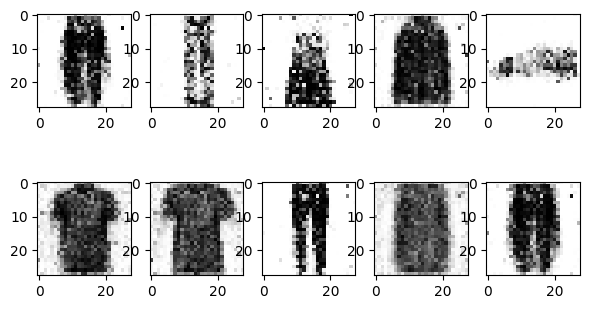

6 0.0 0.0


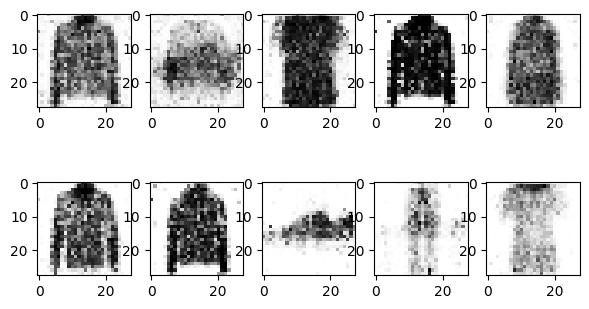

7 0.0 0.0


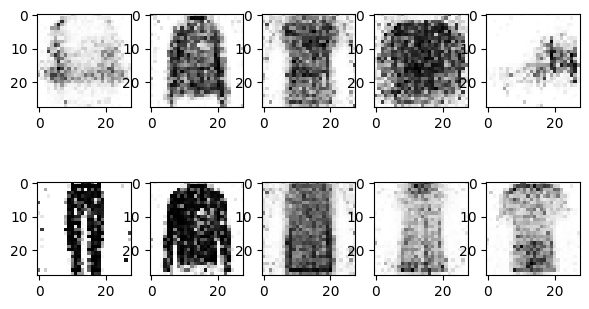

8 0.0 0.0


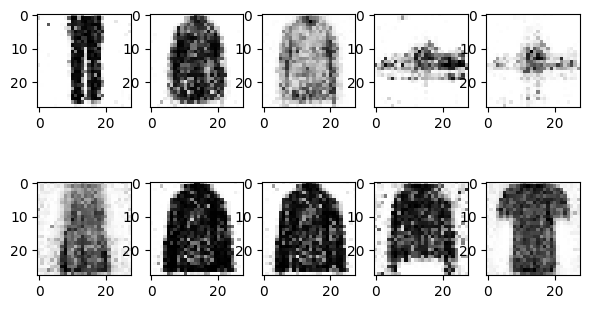

9 0.0 0.0


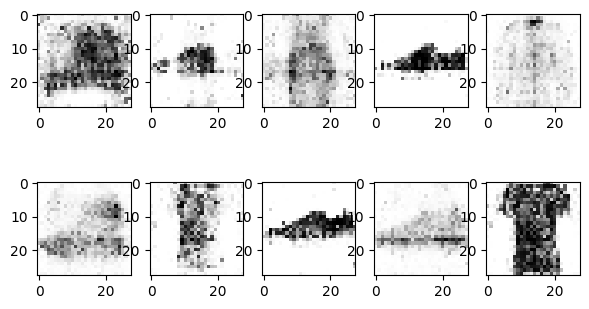

10 0.0 0.0


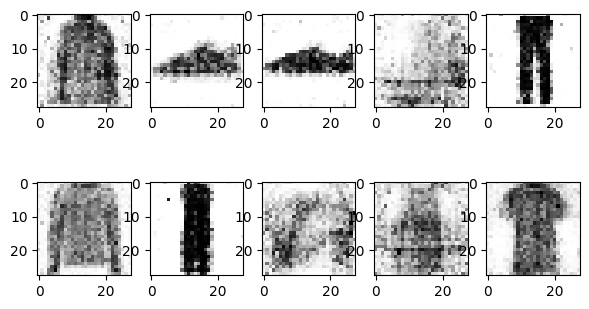

11 0.0 0.0


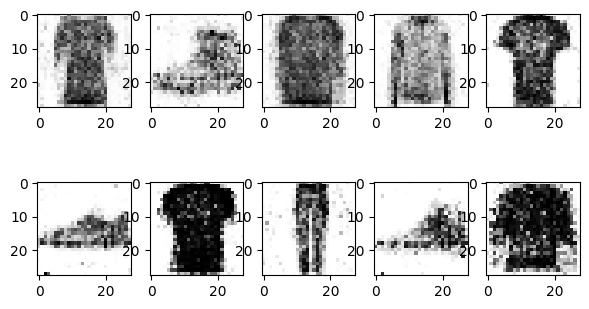

12 0.0 0.0


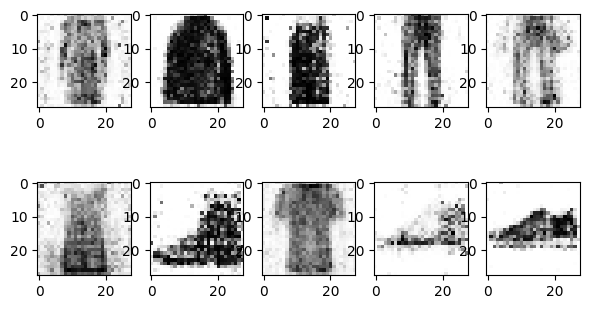

13 0.0 0.0


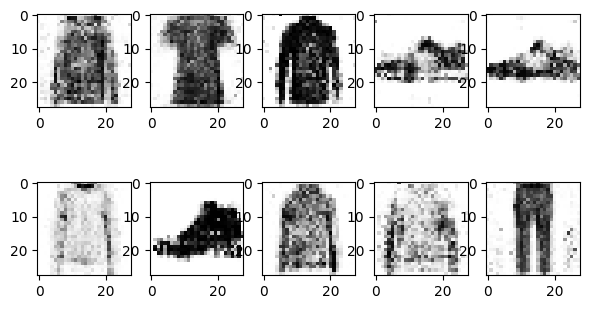

14 0.0 0.0


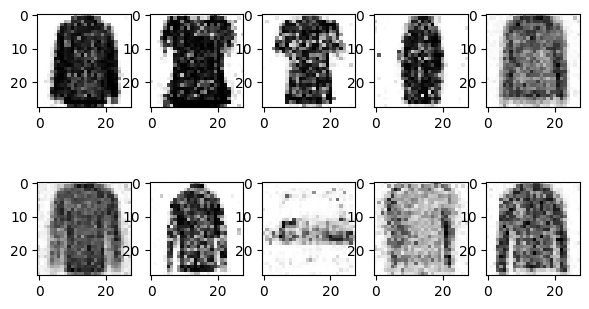

15 0.0 0.0


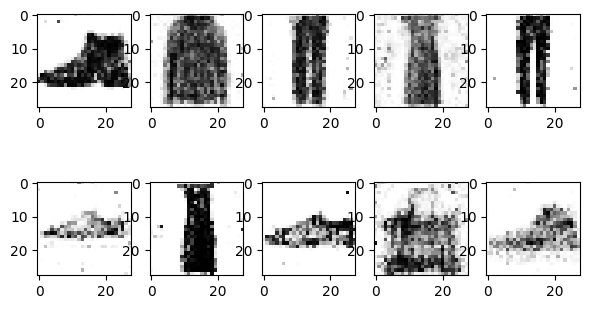

16 0.0 0.0


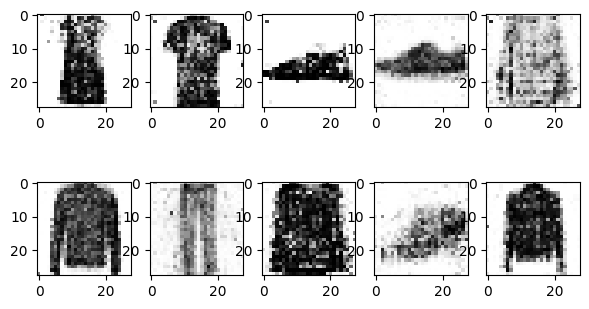

17 0.0 0.0


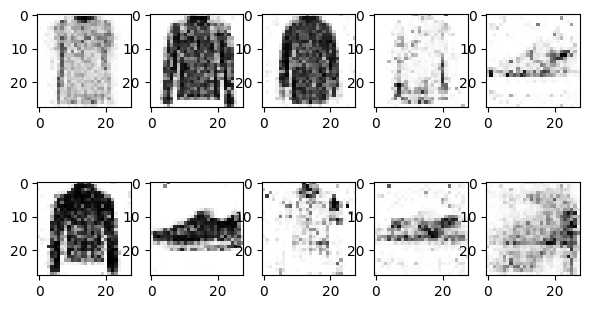

18 0.0 0.0


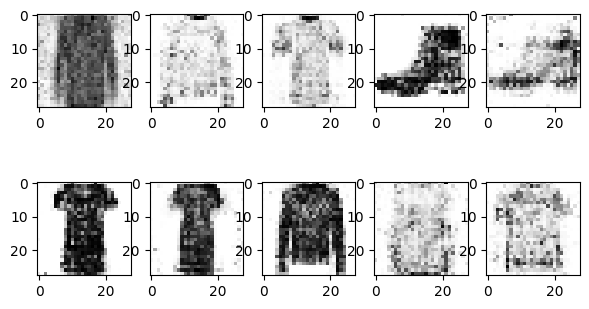

19 0.0 0.0


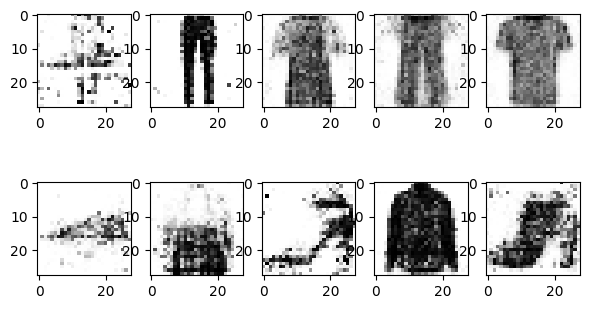

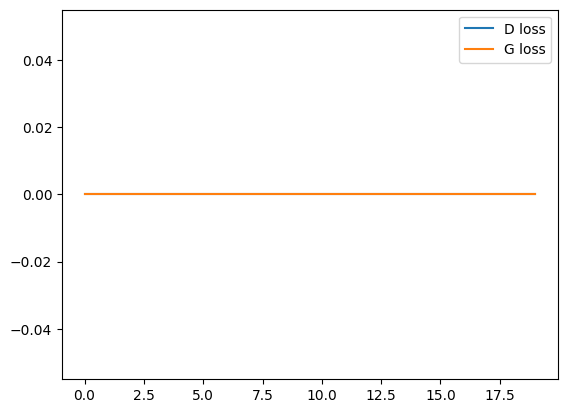

In [14]:
N_EPOCHS = 20

d_losses = []
g_losses = []

for e in range(N_EPOCHS):

  d_loss, g_loss = train_one_epoch(
      d_model, g_model, d_optimizer, g_optimizer, loader, loss_fn, device
  )

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  print(e, d_loss, g_loss)

  gen_fake_batch = generate(g_model, 10, device=device)
  plot_gen_batch(gen_fake_batch, 2, 5)

plt.plot(range(N_EPOCHS), d_losses, label='D loss')
plt.plot(range(N_EPOCHS), g_losses, label='G loss')
plt.legend()
plt.show()

In [15]:
d_example_inputs = dataset[0][0].reshape(1, 28 * 28)
g_example_inputs = torch.randn((1, 100))

d_model.eval()
g_model.eval()

traced_d = torch.jit.trace(d_model.cpu(), example_inputs=d_example_inputs)
traced_g = torch.jit.trace(g_model.cpu(), example_inputs=g_example_inputs)

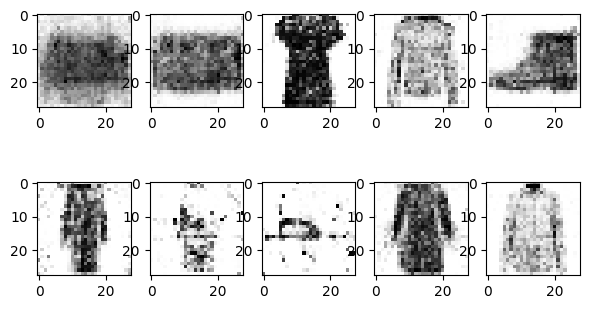

In [16]:
gen_fake_batch = generate(g_model.cuda(), 10, device=device)
plot_gen_batch(gen_fake_batch, 2, 5)

In [17]:
%%timeit

for _ in range(100):
  with torch.no_grad():
    noize = torch.randn((1, 100)).to(device)
    output = g_model(noize)

30.6 ms ± 4.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%timeit

for _ in range(100):
  with torch.no_grad():
    noize = torch.randn((1, 100)).to(device)
    output = traced_g(noize)

29 ms ± 926 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
